<a href="https://colab.research.google.com/github/pavankumarbalijepalli/pr-phi2-vs-defog/blob/main/fine_tune_phi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Exploration

### Install Necessary Modules, Checking Specs and Connecting to Drive

In [1]:
from google.colab import drive

drive.mount('drive')

Mounted at drive


In [2]:
#Check the system specs
!nvidia-smi

Tue Feb 20 11:06:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
!pip install datasets
!pip install -q -U torch=='2.0.0'
!pip install -q -U accelerate=='0.25.0' peft=='0.7.1' bitsandbytes=='0.41.3.post2' trl=='0.7.4'
!pip install -q -U transformers einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 63.3 MB/s eta 0:

### Import EDA Modules

In [4]:
# Data Exploration Imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

### Loading the dataset

In [5]:
from datasets import load_dataset

dataset = load_dataset("b-mc2/sql-create-context")
data_df = dataset['train'].to_pandas()

Generating train split: 0 examples [00:00, ? examples/s]

### Data exploration and processing

In [6]:
data_df.head()

,answer,question,context
0,SELECT COUNT(*) FROM head WHERE age > 56,How many heads of the departments are older th...,CREATE TABLE head (age INTEGER)
1,"SELECT name, born_state, age FROM head ORDER B...","List the name, born state and age of the heads...","CREATE TABLE head (name VARCHAR, born_state VA..."
2,"SELECT creation, name, budget_in_billions FROM...","List the creation year, name and budget of eac...","CREATE TABLE department (creation VARCHAR, nam..."
3,"SELECT MAX(budget_in_billions), MIN(budget_in_...",What are the maximum and minimum budget of the...,CREATE TABLE department (budget_in_billions IN...
4,SELECT AVG(num_employees) FROM department WHER...,What is the average number of employees of the...,CREATE TABLE department (num_employees INTEGER...


<Axes: xlabel='count', ylabel='difficulty'>

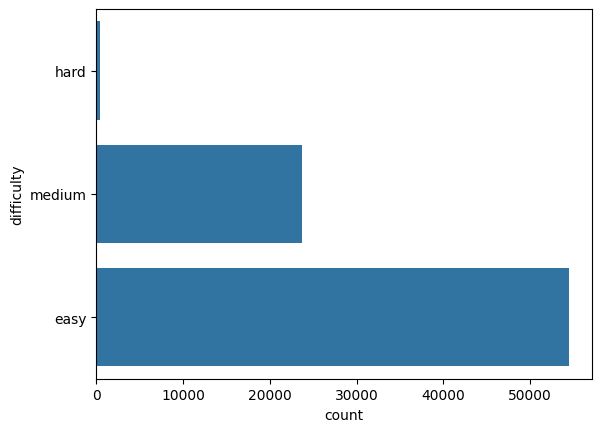

In [7]:
# Finding the complexity of the datapoint
data_df['table_count'] = data_df['context'].apply(lambda x: x.split(' ').count('CREATE'))
data_df['sub_query_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('SELECT'))
data_df['joins_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('JOIN'))
data_df['where_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('WHERE'))
data_df['group_by_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('GROUP BY'))
data_df['columns_count'] = data_df['context'].apply(lambda x: list(x).count(',')) + data_df['table_count']

# Finding the complexity based on the above values
data_df['complexity'] = data_df['table_count'] + data_df['sub_query_count'] + data_df['joins_count'] + data_df['where_count'] + data_df['group_by_count'] + data_df['columns_count']
data_df = data_df.sort_values(by='complexity', ascending=False)

# Marking Difficulty based on threshold
data_df['difficulty'] = data_df['complexity'].apply(lambda x: 'easy' if x < 6 else 'medium' if x < 13 else 'hard')
sns.countplot(data_df['difficulty'])

### Train, test split

In [8]:
# Split data into train and test set also maintaining the ratio in difficulty column
train_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df['difficulty'])
train_df, eval_df = train_test_split(train_df, test_size=0.1, stratify=train_df['difficulty'])

In [9]:
train_df.shape, test_df.shape, eval_df.shape

((63647, 11), (7858, 11), (7072, 11))

## Fine-tuning

### Connect to HF Hub

In [10]:
from huggingface_hub import notebook_login

notebook_login()

### Create Prompt Templates and Map over Dataset

In [11]:
def generate_prompt(data_point):
    return f"""### Task
Generate a SQL query to answer the following question:
`{data_point['question']}`

### Database Schema
The query will run on a database with the following schema:
{data_point['context']}

### Answer
Given the database schema, here is the SQL query that answers `{data_point['question']}`:
```sql
{data_point['answer']}
```""".strip()

def generate_test_prompt(data_point):
    return f"""### Task
Generate a SQL query to answer the following question:
`{data_point['question']}`

### Database Schema
The query will run on a database with the following schema:
{data_point['context']}

### Answer
Given the database schema, here is the SQL query that answers `{data_point['question']}`:
```sql""".strip()

In [12]:
X_train = pd.DataFrame(train_df.apply(generate_prompt, axis=1), columns=["text"])
X_eval = pd.DataFrame(eval_df.apply(generate_prompt, axis=1), columns=["text"])
X_test = pd.DataFrame(test_df.apply(generate_test_prompt, axis=1), columns=["text"])

In [13]:
train_dataset = Dataset.from_pandas(X_train[['text']], preserve_index=False)
eval_dataset = Dataset.from_pandas(X_eval[['text']], preserve_index=False)
test_dataset = Dataset.from_pandas(X_test[['text']], preserve_index=False)

In [14]:
train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['text'],
     num_rows: 63647
 }),
 Dataset({
     features: ['text'],
     num_rows: 7072
 }),
 Dataset({
     features: ['text'],
     num_rows: 7858
 }))

### Load Model and Check Trainable Parameters

In [15]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [16]:
model_name = "microsoft/phi-2"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

print_trainable_parameters(model)

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


trainable params: 262364160 || all params: 1521392640 || trainable%: 17.24


### Make Prediction without Fine-tuning

In [ ]:
def predict(X_test, model, tokenizer):
    y_pred = []
    y_act = []
    for i in tqdm(X_test.iloc):
        # print(i['answer'], '\n', i['question'], '\n', i['context'])
        prompt = generate_test_prompt(i)
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens = 10,
                        temperature = 0.2,
                       )
        result = pipe(prompt, pad_token_id=pipe.tokenizer.eos_token_id)
        answer = result[0]['generated_text']

        y_pred.append(answer)
    return y_pred

In [ ]:
y_pred = predict(test_df.sample(5), model, tokenizer)

5it [00:15,  3.13s/it]


In [ ]:
for pred in y_pred:
  print(pred)
  print('='*120)

### Task
Generate a SQL query to answer the following question:
`Tell me the highest wins for year less than 2000 and best finish of 4 and tournaments played less than 3`

### Database Schema
The query will run on a database with the following schema:
CREATE TABLE table_name_42 (wins INTEGER, tournaments_played VARCHAR, year VARCHAR, best_finish VARCHAR)

### Answer
Given the database schema, here is the SQL query that answers `Tell me the highest wins for year less than 2000 and best finish of 4 and tournaments played less than 3`:
```sql
SELECT wins, year, best_finish
FROM table_name_42
WHERE year < 2000 AND best_finish = '4' AND tournaments_played < 3
ORDER BY wins DESC
LIMIT 1
### Task
Generate a SQL query to answer the following question:
`What was the label in the region of Argentina and had a format of CD?`

### Database Schema
The query will run on a database with the following schema:
CREATE TABLE table_name_82 (label VARCHAR, format VARCHAR, region VARCHAR)

### Answer
Given 

### Find the Target Modules to Train

In [17]:
import re

def get_num_layers(model):
    numbers = set()
    for name, _ in model.named_parameters():
        for number in re.findall(r'\d+', name):
            numbers.add(int(number))
    return max(numbers)

def get_last_layer_linears(model):
    names = []

    num_layers = get_num_layers(model)
    for name, module in model.named_modules():
        if str(num_layers) in name and not "encoder" in name:
            if isinstance(module, torch.nn.Linear):
                names.append(name)
    return names

### Configure Peft, Training Arguments, and Trainer Module

In [18]:
import os

os.makedirs("model")

peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=[
    'q_proj',
    'k_proj',
    'v_proj',
    'dense',
    'fc1',
    'fc2',
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir="model/logs",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=5,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    evaluation_strategy="steps"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    max_seq_length=512,
)

Map:   0%|          | 0/63647 [00:00<?, ? examples/s]

Map:   0%|          | 0/7072 [00:00<?, ? examples/s]

### Prepare Zipping Function to automatically download the model after Training

In [19]:
from zipfile import ZipFile
import os

def get_all_file_paths(directory):
    file_paths = []
    for root, directories, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)
    return file_paths

def zip_it(directory: str, file_name: str):
    file_paths = get_all_file_paths(directory)
    print('Following files will be zipped:')
    for file_path in file_paths:
        print(file_path)
    with ZipFile(file_name,'w') as zip:
        for file in file_paths:
            zip.write(file)
    print('All files zipped successfully!')

### Fine-tune the Model and Push Base to Hub

In [20]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained("model/trained-model")

model.push_to_hub("phi2-sql-cc-qlora-60k",
                  use_auth_token=True,
                  commit_message="Training Phi-2 with 60k, batch 8",
                  private=True)

OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 39.56 GiB total capacity; 38.59 GiB already allocated; 40.81 MiB free; 39.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
zip_it("model", "model.zip")

from datetime import datetime
import shutil

name = 'model_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.zip'
shutil.move("/content/model.zip", "/content/drive/MyDrive/phi2_finetune/" + name)

Following files will be zipped:
model/logs/runs/Feb19_15-38-12_814f95c4358b/events.out.tfevents.1708357110.814f95c4358b.1729.0
model/trained-model/adapter_model.safetensors
model/trained-model/README.md
model/trained-model/adapter_config.json
All files zipped successfully!


'/content/drive/MyDrive/phi2_finetune/model_2024_02_19_16_06_50.zip'

### Stopping the runtime to not lose any resources

In [ ]:
#Terminate the session so we do not incur cost
from google.colab import runtime
runtime.unassign()

## Evaluating Fine-Tuned Model

In [ ]:
model_name = "microsoft/phi-2"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# print_trainable_parameters(model)

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from peft import PeftModel, PeftConfig
#Load the model weights from hub
model_id = "pavankumarbalijepalli/phi2-sql-cc-qlora-test-400"
trained_model = PeftModel.from_pretrained(model, model_id)

print(trained_model)
# #Run inference
# outputs = trained_model.generate(**inputs, max_length=1000)
# text = tokenizer.batch_decode(outputs,skip_special_tokens=True)[0]
# print(text)

adapter_config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/94.4M [00:00<?, ?B/s]

In [ ]:
trained_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4

In [ ]:
y_pred = predict(test_df.sample(5), trained_model, tokenizer)

0it [00:00, ?it/s]The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCaus

In [ ]:
y_pred

["### Task\nGenerate a SQL query to answer the following question:\n`Show customer ids who don't have an account.`\n\n### Database Schema\nThe query will run on a database with the following schema:\nCREATE TABLE Customers (customer_id VARCHAR); CREATE TABLE Accounts (customer_id VARCHAR)\n\n### Answer\nGiven the database schema, here is the SQL query that answers `Show customer ids who don't have an account.`:\n```sql\nSELECT Customers.customer_id FROM Customers WHERE Accounts.customer_id IS NULL\n```\n\n### Explanation\nThe query runs on a database with the following schema:\nCREATE TABLE Customers (customer_id V",
 '### Task\nGenerate a SQL query to answer the following question:\n`What is the frequency of the model with part number lf80537gf0411m?`\n\n### Database Schema\nThe query will run on a database with the following schema:\nCREATE TABLE table_11602313_4 (frequency VARCHAR, part_number_s_ VARCHAR)\n\n### Answer\nGiven the database schema, here is the SQL query that answers `

In [ ]:
evaluation = pd.DataFrame({'text': X_test["text"],
                           'y_true':y_true,
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)